# Initialization

In [1]:
import os
import random

from itertools import permutations
from string import punctuation

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import seaborn as sns

import numpy as np 
import pandas as pd

import torch 
import torch.nn as nn 

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from nltk.probability import FreqDist

from gensim.models import KeyedVectors
from gensim.models import FastText

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

In [2]:
opt_seed = 9

random.seed(opt_seed)
np.random.seed(opt_seed)
torch.manual_seed(opt_seed)

In [3]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [4]:
pretrained_model = KeyedVectors.load_word2vec_format(
    os.getcwd() + os.sep + "GoogleNews-vectors-negative300.bin", binary=True
)

In [5]:
pca_model = PCA(n_components = 2)
svd_model = TruncatedSVD(n_components = 2)
tsne_model = TSNE(n_components = 2)

pca_model_3d = PCA(n_components = 3)
svd_model_3d = TruncatedSVD(n_components = 3)
tsne_model_3d = TSNE(n_components = 3)

In [6]:
chk_len = lambda t, mn, mx: mn < len(t) < mx

In [7]:
def preprocess_data(f_tokenizer, f_lemmatizer, stop_words, punctuation, data):
    tokens = f_tokenizer(data.lower())
    lemmas = [f_lemmatizer.lemmatize(t) for t in tokens]
    return [t for t in lemmas if t not in stop_words and t not in punctuation and chk_len(t, 2, 20)]

In [8]:
def flat_nested(nested):
    flatten = []
    for item in nested:
        if isinstance(item, list):
            flatten.extend(item)
        else:
            flatten.append(item)
    return flatten

In [9]:
# defined for columns with binary values
def bar_plot_sizes(frame, col_name, a = 6, b = 8):
    
    sizes = [
        len(frame[col_name][frame[col_name] == 0]), 
        len(frame[col_name][frame[col_name] == 1])
    ]
    
    plt.figure(figsize = (a, b))
    
    plt.title('Number of texts per type')
    plt.ylabel('Number of occurences', fontsize = 12)
    plt.xlabel('Text type', fontsize = 12)
    
    axes_current = sns.barplot(x = ['non-labeled', 'labeled'], y = sizes)
    
    plot_objects = axes_current.patches
    plot_labels = sizes
    for rect, label in zip(plot_objects, plot_labels):
        height = rect.get_height()
        axes_current.text(
            rect.get_x() + rect.get_width() / 2, 
            height + 5, label, 
            ha = 'center', va = 'bottom')

    plt.show()

In [10]:
df_train = pd.read_csv('train.csv')
df_train.columns = ['example_id', 'text', 'label']
df_train.label = df_train.label.astype('int32')

In [11]:
df_train.head(15)

,example_id,text,label
0,140d03eabb7cb5c2558605eb8336689c,brandpost best of both worlds hybrid onsite an...,0
1,f7f1f906c9e2b76e63020f8794516185,$mention$ they shall in all cases except treas...,0
2,39f0b2ebc12e008a7a43ec318d0c3874,lifelock offers to protect you from the equifa...,0
3,ad4e57c69f00548253cb6d47b15c3ce4,skimmer adware spent two months in google play...,1
4,236bfe8f2f145dbcf17be122546946db,just want to love and be loved,0
5,f9f0419dd6ec37b9f72a8a8292a37d0b,cyber attack on barts nhs trust eloited zeroda...,1
6,3e23b538a07b92f2e27b6964dd30242b,docusigns customer email database accessed by ...,1
7,991a2ba0398b4b4bc63201141a401207,ddos real threat that big data can help combat...,1
8,ee2971e296b39717c23e070ef08f64b3,cyberattack glossary thaw are malware phassach...,0
9,a1c2ec94210674309d9896540f6894c8,malware is not going away trust your network s...,0


In [12]:
df_train.shape

(1189, 3)

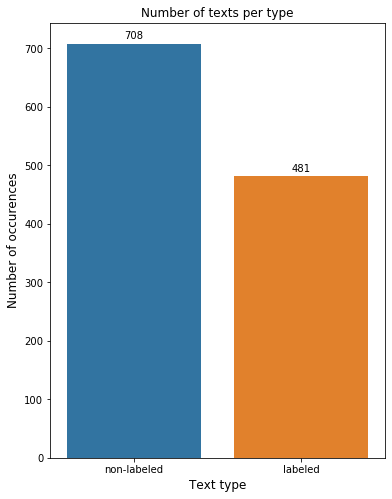

In [13]:
bar_plot_sizes(df_train, 'label')

In [14]:
df_train['cleaned'] = df_train['text'].apply(
    lambda u: preprocess_data(word_tokenize, lemmatizer, stop_words, punctuation, u)
)

In [15]:
df_train['cleaned'].head(15)

0     [brandpost, best, world, hybrid, onsite, cloud...
1     [mention, shall, case, except, treason, felony...
2     [lifelock, offer, protect, equifax, breach, se...
3     [skimmer, adware, spent, two, month, google, p...
4                                   [want, love, loved]
5     [cyber, attack, bart, trust, eloited, zeroday,...
6     [docusigns, customer, email, database, accesse...
7     [ddos, real, threat, big, data, help, combat, ...
8     [cyberattack, glossary, thaw, malware, phassac...
9     [malware, going, away, trust, network, securit...
10    [new, mac, malware, loose, need, know, url, vi...
11    [fbi, investigating, reported, data, breach, a...
12    [great, article, phishing, avoid, click, bad, ...
13                   [equifax, breach, every, day, url]
14         [cost, freeze, credit, equifax, breach, url]
Name: cleaned, dtype: object

In [16]:
cnt_vocab = FreqDist(flat_nested(df_train['cleaned'].tolist()))

In [17]:
cnt_vocab.most_common(15)

[('url', 812),
 ('breach', 417),
 ('malware', 338),
 ('mention', 212),
 ('vulnerability', 205),
 ('security', 145),
 ('phishing', 132),
 ('data', 125),
 ('attack', 99),
 ('equifax', 96),
 ('ddos', 87),
 ('via', 72),
 ('cybersecurity', 67),
 ('infosec', 62),
 ('new', 60)]

In [18]:
lim_cnt_min = 4
lim_cnt_max = 1e3

In [19]:
cleaned_vocab = [tok for tok, cnt in cnt_vocab.items() if lim_cnt_min < cnt < lim_cnt_max]

In [20]:
cleaned_vocab.append(" ")
cleaned_vocab = set(cleaned_vocab)

In [21]:
print(
    "Size of vocab:\n"
    "Before filtering: {:5}\n"
    "After  filtering: {:5}".format(len(cnt_vocab), len(cleaned_vocab))
)

Size of vocab:
Before filtering:  3972
After  filtering:   423


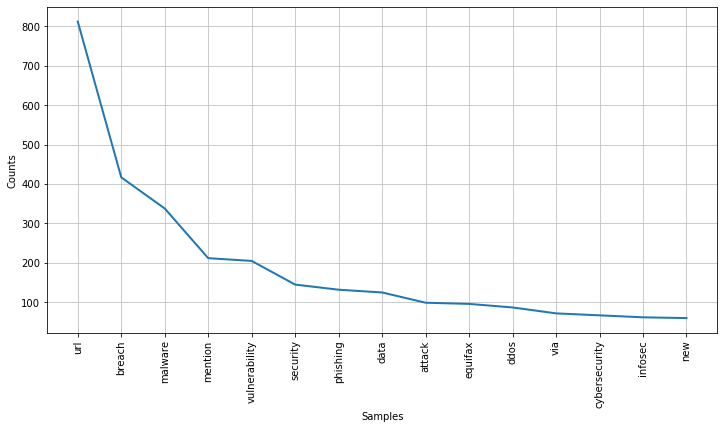

In [22]:
plt.figure(figsize = (12, 6))

FreqDist(flat_nested(df_train['cleaned'].tolist())).plot(15, cumulative = False)

In [23]:
#df_train.to_pickle(os.getcwd() + os.sep + "train_set.pkl")

Если мне лень будет запускать код вплоть до этого момента

In [24]:
#df_train.from_pickle(os.getcwd() + os.sep + "train_set.pkl")

In [25]:
N = 25

In [26]:
def fast_barplot(X, N, c = 'black'):
    freq_dist = FreqDist(X)
    plt_df = pd.DataFrame()
    plt_df['keys'] = list(freq_dist.keys())
    plt_df['values'] = list(freq_dist.values())
    plt_df = plt_df.sort_values(by = ['values'], ascending = False).reset_index(drop=True)
    sns.barplot(x = 'keys', y = 'values', data = plt_df[:N], color = c)

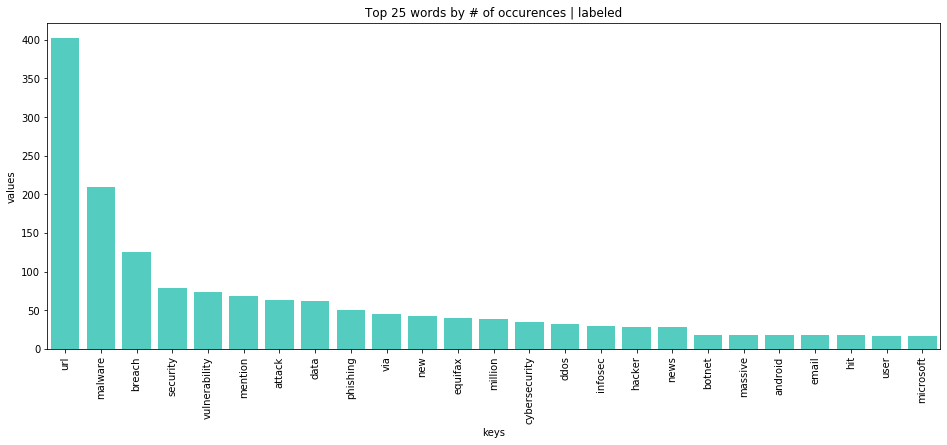

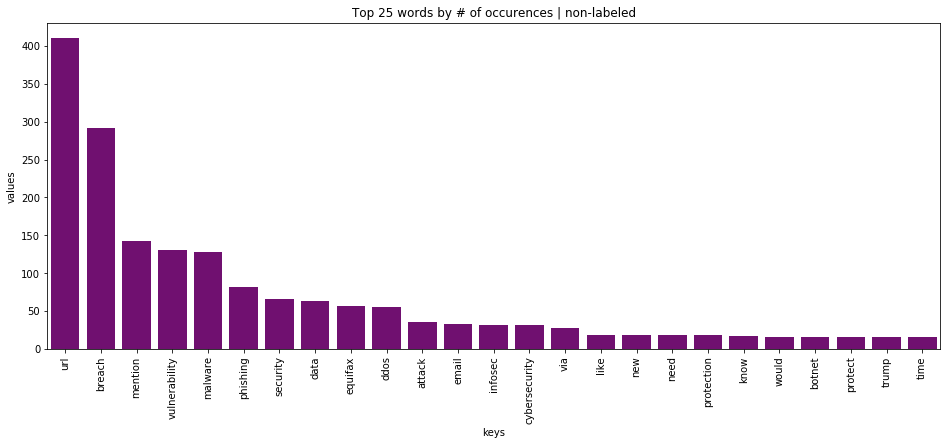

In [27]:
plt.figure(figsize = (16, 6))
plt.xticks(rotation='vertical')
plt.title('Top {} words by # of occurences | labeled'.format(N))
fast_barplot(flat_nested(df_train['cleaned'][df_train['label'] == 1].tolist()), N, 'turquoise')

plt.figure(figsize = (16, 6))
plt.xticks(rotation='vertical')
plt.title('Top {} words by # of occurences | non-labeled'.format(N))
fast_barplot(flat_nested(df_train['cleaned'][df_train['label'] == 0].tolist()), N, 'purple')

In [28]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

In [29]:
def purple_recolor(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(280, %d%%, %d%%)" % (random.randint(75, 100), random.randint(35, 55))

In [30]:
M = 300
w, h = 1200, 600

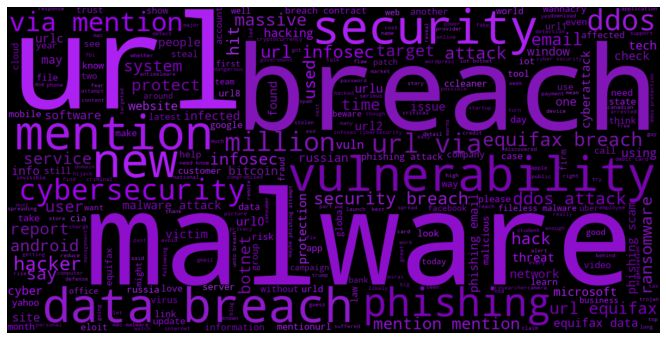

In [31]:
text = ' '.join([' '.join(e) for e in df_train['cleaned']])

cloud = WordCloud(
    width=w, height=h,
    contour_color="white", max_words=M,
    relative_scaling = 0, background_color = "black"
).generate(text)

plt.figure(figsize=[12,6])
plt.imshow(cloud.recolor(color_func=purple_recolor, random_state=4),
           interpolation="bilinear")
plt.axis("off")
plt.show()

In [32]:
df_test = pd.read_csv('test.csv')
df_test.columns = ['example_id', 'text']

In [33]:
df_test.head(15)

,example_id,text
0,24bf52cc84b75bce8ee9c0cdd0b5117f,phishing heads to the cloud forbes $url$ cloud
1,708cc462eca0c274bcff304bbc4396f8,Sports Direct Failed to Tell Staff of Data Bre...
2,c5da1d371af9525d2fc2174311e3dae4,understanding vulnerability through humanright...
3,844f5f5be464a0600891ac6b8c1a1afd,cussword manager onelogin hit by data breach $...
4,97daba48c36db68f3e84ebcbf8952aa2,vuln multiple flexense products cve20177310 bu...
5,5aa7363096040ffc17b20f595edda878,update 3equifax ceo departs forgoes bonus afte...
6,a096ea460d0c9f2af7211c8f2d1d7ee7,trading card maker topps hit by security breac...
7,ff4a30ad03aa3b4485a542dd32919722,icymi up diliman dean convicted of ethics brea...
8,0841f6a99ed3dd2ba9b8cec3b0a1451c,google is using artificial intelligence to cut...
9,6d368e9b25aebb7bfbda01c4eb7533f4,equifax accidentally sent hack victims to phis...


In [34]:
df_test['cleaned'] = df_test['text'].apply(
    lambda u: preprocess_data(word_tokenize, lemmatizer, stop_words, punctuation, u)
)

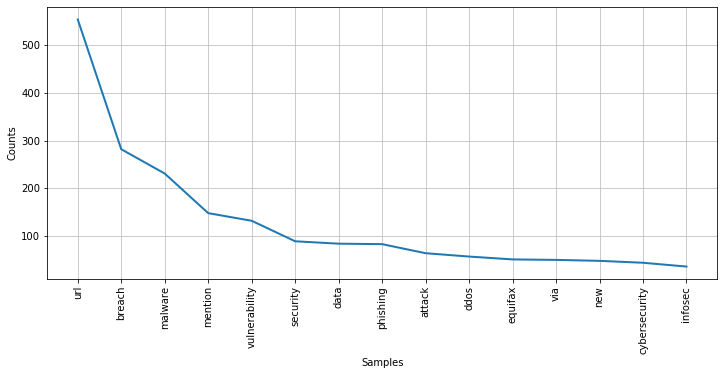

In [35]:
plt.figure(figsize = (12, 5))

FreqDist(flat_nested(df_test['cleaned'].tolist())).plot(15, cumulative = False)

In [36]:
print(
    len(df_train[df_train.cleaned.astype(str) == '[]']),
    len(df_test[df_test.cleaned.astype(str) == '[]'])
)

0 0


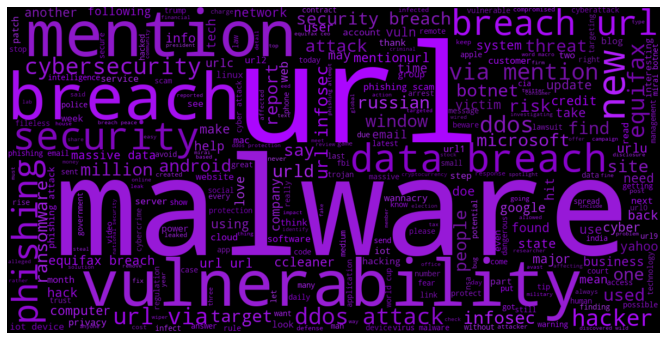

In [37]:
text = ' '.join([' '.join(e) for e in df_test['cleaned']])

cloud = WordCloud(
    width=w, height=h,
    contour_color="white", max_words=M,
    relative_scaling = 0, background_color = "black"
).generate(text)

plt.figure(figsize=[12,6])
plt.imshow(cloud.recolor(color_func=purple_recolor, random_state=3),
           interpolation="bilinear")
plt.axis("off")
plt.show()

In [38]:
test_cnt_vocab = FreqDist(flat_nested(df_test['cleaned'].tolist()))
test_cleaned_vocab = set(
    [tok for tok, cnt in test_cnt_vocab.items() if lim_cnt_min < cnt < lim_cnt_max]
)

In [39]:
full_vocab = cleaned_vocab | test_cleaned_vocab

In [40]:
print('Size of full vocabulary is: {}'.format(len(full_vocab)))

Size of full vocabulary is: 462


In [41]:
token_to_id = {v: k for k, v in enumerate(sorted(full_vocab))}
id_to_token = {v: k for k, v in token_to_id.items()}

In [42]:
df_train['cleaned_vocab'] = df_train['cleaned'].apply(
    lambda u: [v for v in u if v in full_vocab]
)

df_test['cleaned_vocab'] = df_test['cleaned'].apply(
    lambda u: [v for v in u if v in full_vocab]
)

In [43]:
df_train.head(4)

,example_id,text,label,cleaned,cleaned_vocab
0,140d03eabb7cb5c2558605eb8336689c,brandpost best of both worlds hybrid onsite an...,0,"[brandpost, best, world, hybrid, onsite, cloud...","[best, world, ddos, protection, url]"
1,f7f1f906c9e2b76e63020f8794516185,$mention$ they shall in all cases except treas...,0,"[mention, shall, case, except, treason, felony...","[mention, case, breach, peace, arrest]"
2,39f0b2ebc12e008a7a43ec318d0c3874,lifelock offers to protect you from the equifa...,0,"[lifelock, offer, protect, equifax, breach, se...","[offer, protect, equifax, breach, service, equ..."
3,ad4e57c69f00548253cb6d47b15c3ce4,skimmer adware spent two months in google play...,1,"[skimmer, adware, spent, two, month, google, p...","[two, month, google, play, researcher, malware..."


In [44]:
df_test.head(4)

,example_id,text,cleaned,cleaned_vocab
0,24bf52cc84b75bce8ee9c0cdd0b5117f,phishing heads to the cloud forbes $url$ cloud,"[phishing, head, cloud, forbes, url, cloud]","[phishing, cloud, url, cloud]"
1,708cc462eca0c274bcff304bbc4396f8,Sports Direct Failed to Tell Staff of Data Bre...,"[sport, direct, failed, tell, staff, data, bre...","[data, breach, url]"
2,c5da1d371af9525d2fc2174311e3dae4,understanding vulnerability through humanright...,"[understanding, vulnerability, humanrights, me...","[vulnerability, mention, urlu]"
3,844f5f5be464a0600891ac6b8c1a1afd,cussword manager onelogin hit by data breach $...,"[cussword, manager, onelogin, hit, data, breac...","[hit, data, breach, url, via, url]"


In [45]:
print(
    len(df_train[df_train.cleaned_vocab.astype(str) == '[]']),
    len(df_test[df_test.cleaned_vocab.astype(str) == '[]'])
)

3 1


In [46]:
def frame_predictions(X, y, Xy_idx):
    preds_df = pd.DataFrame()
    preds_df['example_id'] = X['example_id']
    preds_df['label'] = np.array(np.zeros(len(X)), dtype = bool)
    preds_df['label'][Xy_idx] = y
    return preds_df

In [47]:
def del_outliners(X):
    X_q2 = np.median(X)
    
    X_s = np.sort(X)
    
    X_q1 = np.median(X_s[X_s <= X_q2])
    X_q3 = np.median(X_s[X_s >= X_q2])
    
    X_iqr = X_q3 - X_q1
    
    min_lim = X_q1 - 1.5 * X_iqr
    max_lim = X_q3 + 1.5 * X_iqr
    
    return X[(min_lim <= X) & (X <= max_lim)]

In [48]:
lengths = df_train.text.str.split().apply(len)

In [49]:
print(np.mean(lengths))

14.352396972245584


(array([0.02153209, 0.01987578, 0.03395445, 0.04057971, 0.06542443,
        0.08447205, 0.08778468, 0.08198758, 0.0679089 , 0.08115942,
        0.05465839, 0.05217391, 0.06045549, 0.04803313, 0.03478261,
        0.02981366, 0.01987578, 0.0173913 , 0.01904762, 0.01573499,
        0.01076605, 0.00910973]),
 array([ 4.        ,  5.04545455,  6.09090909,  7.13636364,  8.18181818,
         9.22727273, 10.27272727, 11.31818182, 12.36363636, 13.40909091,
        14.45454545, 15.5       , 16.54545455, 17.59090909, 18.63636364,
        19.68181818, 20.72727273, 21.77272727, 22.81818182, 23.86363636,
        24.90909091, 25.95454545, 27.        ]),
 <a list of 22 Patch objects>)

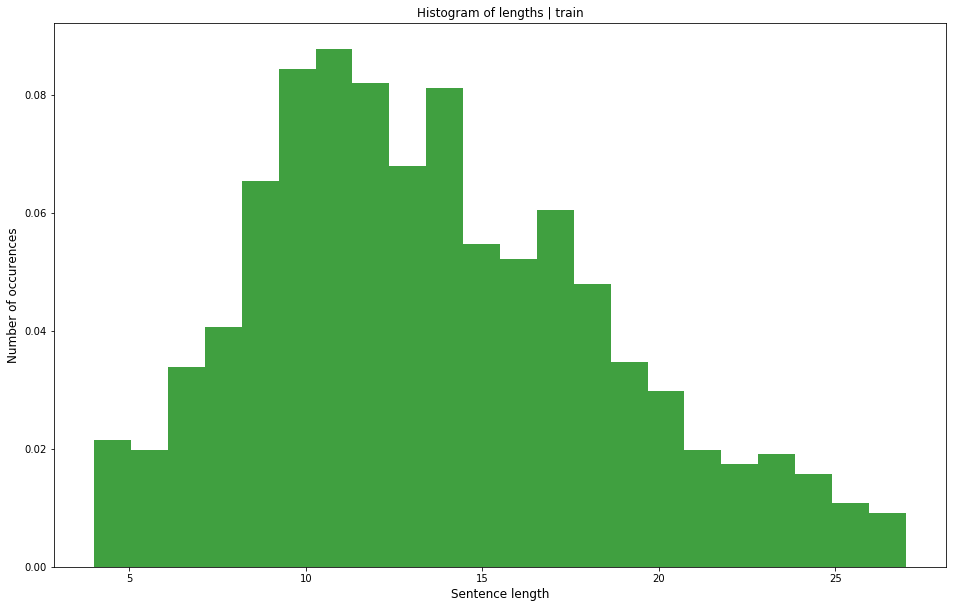

In [50]:
plt.figure(figsize = (16, 10))

plt.title('Histogram of lengths | train')
plt.ylabel('Number of occurences', fontsize = 12)
plt.xlabel('Sentence length', fontsize = 12)

plt.hist(del_outliners(lengths), density = True, bins=22, alpha = 0.75, color = "green")

In [51]:
lengths = df_test.text.str.split().apply(len)

(array([0.00520833, 0.01302083, 0.015625  , 0.03515625, 0.04427083,
        0.06770833, 0.06380208, 0.09635417, 0.09244792, 0.07942708,
        0.05989583, 0.0703125 , 0.06640625, 0.06380208, 0.05338542,
        0.03776042, 0.0234375 , 0.03645833, 0.01692708, 0.02213542,
        0.02083333, 0.015625  ]),
 array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.,
        17., 18., 19., 20., 21., 22., 23., 24., 25., 26.]),
 <a list of 22 Patch objects>)

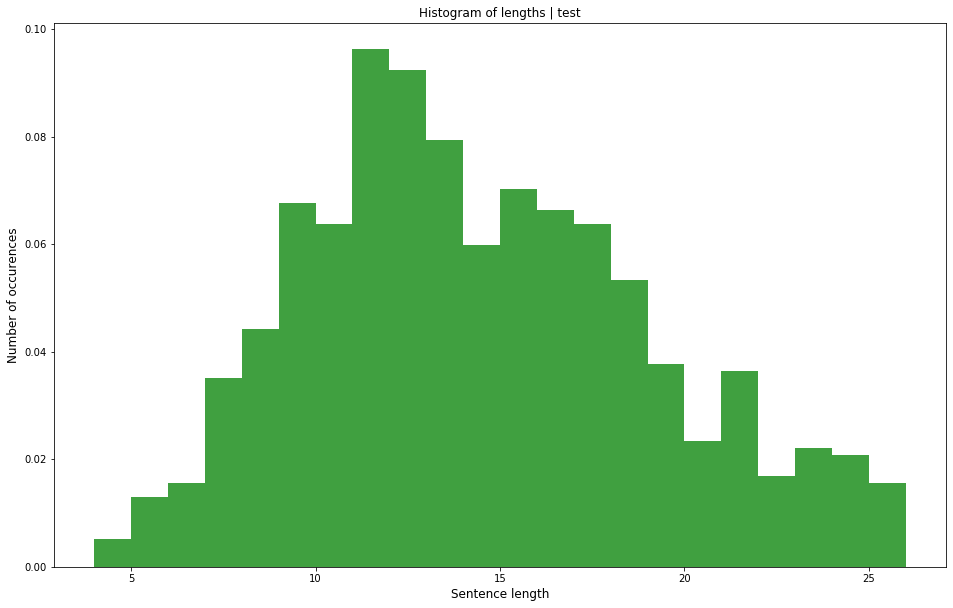

In [52]:
plt.figure(figsize = (16, 10))

plt.title('Histogram of lengths | test')
plt.ylabel('Number of occurences', fontsize = 12)
plt.xlabel('Sentence length', fontsize = 12)

plt.hist(del_outliners(lengths), density = True, bins=22, alpha = 0.75, color = "green")

In [53]:
lengths = df_train.cleaned_vocab.apply(len)

(array([ 67., 124., 156., 185., 194., 158., 106., 119.]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 8 Patch objects>)

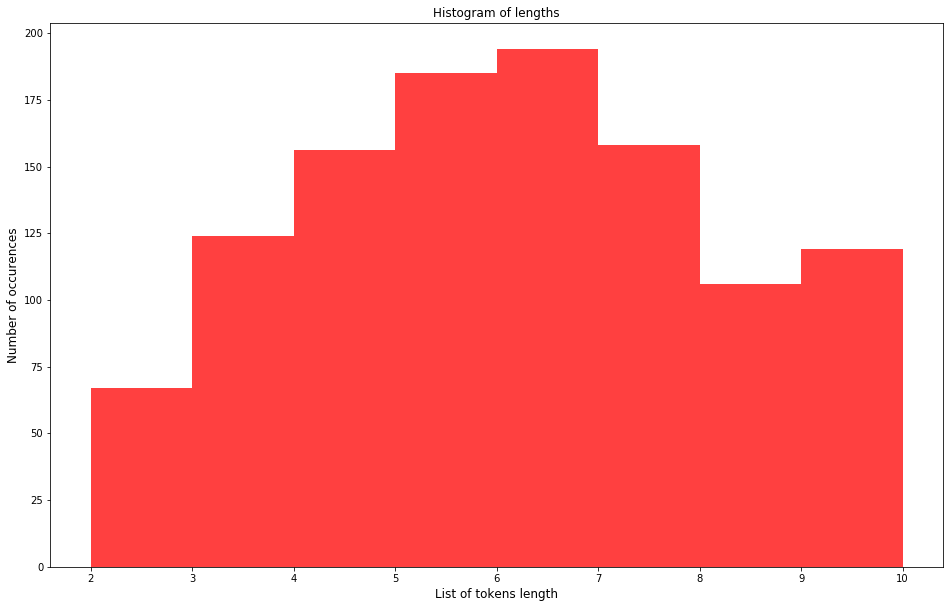

In [54]:
plt.figure(figsize = (16, 10))

plt.title('Histogram of lengths')
plt.ylabel('Number of occurences', fontsize = 12)
plt.xlabel('List of tokens length', fontsize = 12)

plt.hist(del_outliners(lengths), density = False, bins=8, alpha = 0.75, color = "red")

In [55]:
lengths_vocab = np.array(list(map(len, cleaned_vocab)))
lengths_vocab

array([ 6,  3,  8,  6,  4,  4,  7,  7,  7,  8,  7,  4,  8,  6,  4,  3,  5,
        6,  7,  5,  5,  6,  8,  4,  4,  8,  3,  5,  7,  6,  6,  8,  4,  9,
        5,  6,  3,  6,  6,  5,  9,  5,  3, 13,  5,  6,  7,  9,  4,  7,  6,
        4,  3,  3,  4,  8,  7,  3,  4,  6,  6,  4,  3,  8,  9, 11,  6,  5,
        7,  3,  8,  8,  5,  3, 12,  4,  8,  9,  9,  4,  4,  4, 13,  5, 10,
        4,  6,  4,  7,  4,  8,  8,  4,  3,  4,  8, 10,  6,  4,  5,  5,  5,
        5,  5,  6,  4,  8,  4,  6,  5,  8,  6,  3,  4,  3,  6,  4,  3,  3,
        5,  5,  4,  4,  4,  6,  4,  4, 10,  4,  5,  7, 10,  4,  6, 10,  6,
        3,  4,  4,  4,  6,  6,  4,  7,  3,  7,  8,  3,  8,  4,  7,  6,  5,
        6,  7,  8,  7,  3,  5,  3,  5,  7,  3,  4,  5,  5,  5,  5,  5,  5,
        7,  8,  4,  7,  3,  4,  9,  4,  9,  6,  4,  6,  6,  3,  5,  8,  3,
        8,  5,  4,  4,  6,  3,  4,  4,  9,  6,  6,  4,  5,  4,  4,  7, 10,
        5,  5,  4,  4,  5,  9,  6, 10,  9, 14,  4,  4,  6,  6,  4,  6,  7,
        5,  7,  5,  5,  7

(array([  1.,   0.,   0.,  43.,   0., 104.,   0.,  73.,   0.,  67.,   0.,
         51.,  40.,   0.,  16.,   0.,  17.,   0.,   6.,   0.,   1.,   0.,
          2.,   2.]),
 array([ 1.        ,  1.54166667,  2.08333333,  2.625     ,  3.16666667,
         3.70833333,  4.25      ,  4.79166667,  5.33333333,  5.875     ,
         6.41666667,  6.95833333,  7.5       ,  8.04166667,  8.58333333,
         9.125     ,  9.66666667, 10.20833333, 10.75      , 11.29166667,
        11.83333333, 12.375     , 12.91666667, 13.45833333, 14.        ]),
 <a list of 24 Patch objects>)

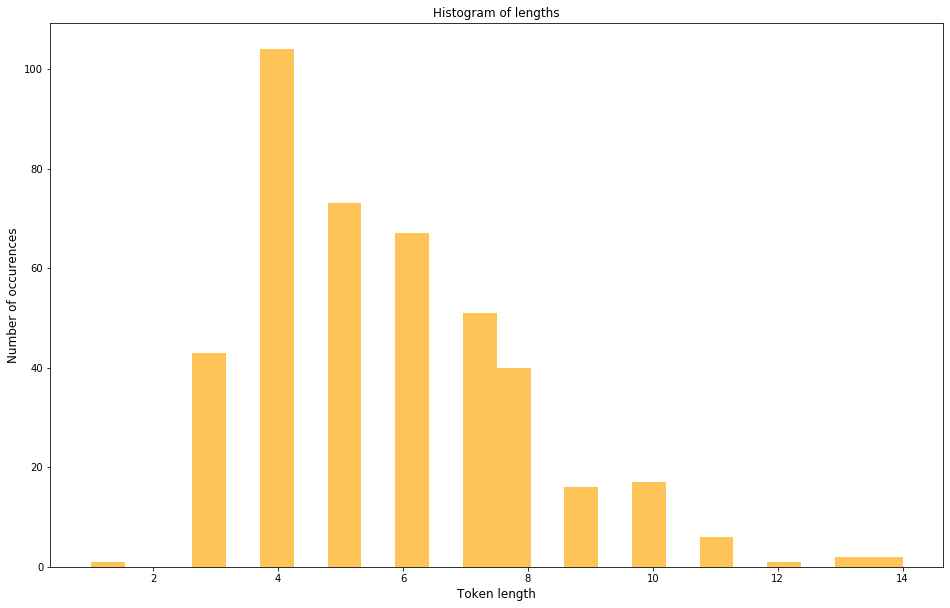

In [56]:
plt.figure(figsize = (16, 10))

plt.title('Histogram of lengths')
plt.ylabel('Number of occurences', fontsize = 12)
plt.xlabel('Token length', fontsize = 12)

plt.hist(lengths_vocab, density = False, bins=24, alpha = 0.65, color = "orange")

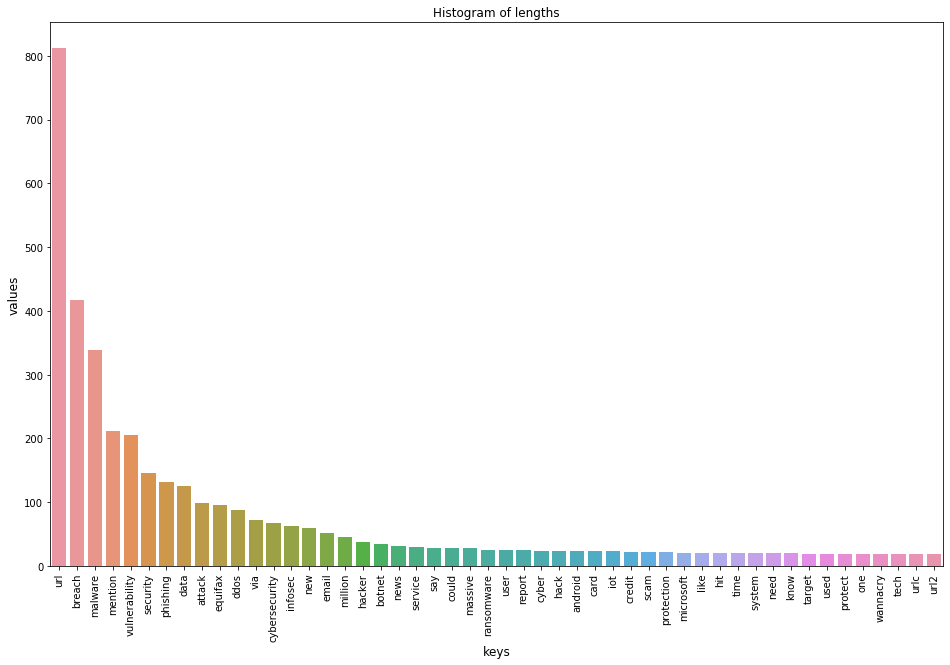

In [57]:
plt.figure(figsize = (16, 10))

plt.title('Histogram of lengths')
plt.ylabel('Number of occurences', fontsize = 12)
plt.xticks(rotation='vertical')
plt.xlabel('Token', fontsize = 12)

from collections import Counter
cnt_vv = Counter(flat_nested(df_train.cleaned_vocab.tolist()))

plt_df = pd.DataFrame()
plt_df['keys'] = list(cnt_vv.keys())
plt_df['values'] = list(cnt_vv.values())
plt_df = plt_df.sort_values(by = ['values'], ascending = False).reset_index(drop=True)

L = 50

sns.barplot(x = 'keys', y = 'values', data = plt_df[:L])

# FastText on df_train

In [58]:
ft_model_train = FastText(sentences = df_train.cleaned_vocab.tolist(), 
                                size      = 300,
                                min_count = 5,
                                window    = 5)

In [59]:
N_epochs = 20
ft_model_train.train(sentences      = df_train.cleaned_vocab.tolist(), 
                           total_examples = ft_model_train.corpus_count,
                           epochs         = N_epochs)

In [60]:
#ft_model_train.wv.vocab

# More visualizations

In [61]:
def fast_scatter(X, l1_idx, l2_idx, i = 0, j = 1, text = '', axs = None, al = 0.75, rd = 16):
    plt.title(text)
    
    c1 = X[l1_idx]
    c2 = X[l2_idx]
    
    ax=plt.subplot()

    ax.scatter(c1[:,i], c1[:,j], alpha=al, c='green', s=rd)
    ax.scatter(c2[:,i], c2[:,j], alpha=al, c='orange', s=rd)

In [62]:
def get_token_vector(tokens_list, word_model, predef_vocab, tfidf_matr = None, i = None):
    s_t = np.zeros((1, word_model.vector_size))
    if tfidf_matr is None:
        for j in range(len(tokens_list)):
            try:
                s_t += word_model[tokens_list[j]]
            except (KeyError, ValueError):
                continue
    else:
        for j in range(len(tokens_list)):
            try:
                tt = tokens_list[j]
                tq = tfidf_matr[i, predef_vocab[tt]]
                s_t += word_model[tt] * tq
            except (KeyError, ValueError):
                continue
    return s_t


def get_corpus_matrix(corpus, word_model, predef_vocab, weights = False):
    corpus_len = len(corpus)
    sparse_matr = np.empty((corpus_len, word_model.vector_size))
    tfidf_matr = None if not weights else TfidfVectorizer(vocabulary = predef_vocab).fit_transform(
        [' '.join(e) for e in corpus])
    for i in range(corpus_len):
        sparse_matr[i] = get_token_vector(corpus[i], word_model, predef_vocab, tfidf_matr, i)
    return sparse_matr

In [63]:
tfidf_transformer = TfidfVectorizer(vocabulary = cleaned_vocab)

In [64]:
bow_transformer = CountVectorizer(vocabulary = cleaned_vocab)

In [65]:
df_train_tfidf = tfidf_transformer.fit_transform([' '.join(e) for e in df_train.cleaned_vocab])

In [66]:
df_train_bow = bow_transformer.fit_transform([' '.join(e) for e in df_train.cleaned_vocab])

In [67]:
df_train_w2v_pretrained = get_corpus_matrix(
    df_train.cleaned_vocab, pretrained_model, dict(zip(full_vocab, range(len(full_vocab)))), weights = True
)

In [68]:
proj_tfidf_train = svd_model.fit_transform(df_train_tfidf)

In [69]:
proj_bow_train = pca_model.fit_transform(df_train_bow.toarray())

In [70]:
proj_w2v_train = tsne_model.fit_transform(df_train_w2v_pretrained)

In [71]:
idxx1 = df_train.label[df_train.label == 0].index
idxx2 = df_train.label[df_train.label != 0].index

c:\users\laplace-transform\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


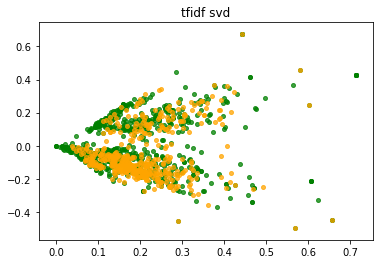

In [72]:
fast_scatter(proj_tfidf_train, idxx1, idxx2, i = 0, j = 1, text = 'tfidf svd')

c:\users\laplace-transform\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


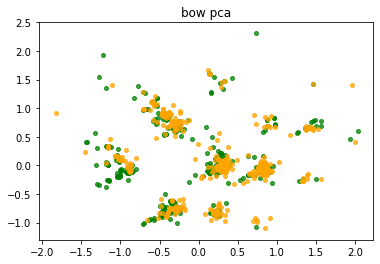

In [73]:
fast_scatter(proj_bow_train, idxx1, idxx2, i = 0, j = 1, text = 'bow pca')

c:\users\laplace-transform\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


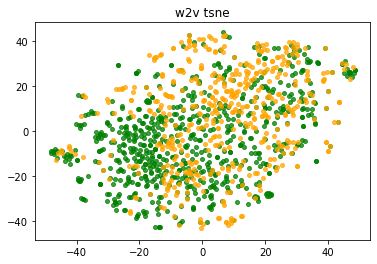

In [74]:
fast_scatter(proj_w2v_train, idxx1, idxx2, i = 0, j = 1, text = 'w2v tsne')

In [75]:
proj_tfidf_train_3d = svd_model_3d.fit_transform(df_train_tfidf)
proj_bow_train_3d = pca_model_3d.fit_transform(df_train_bow.toarray())
proj_w2v_train_3d = tsne_model_3d.fit_transform(df_train_w2v_pretrained)

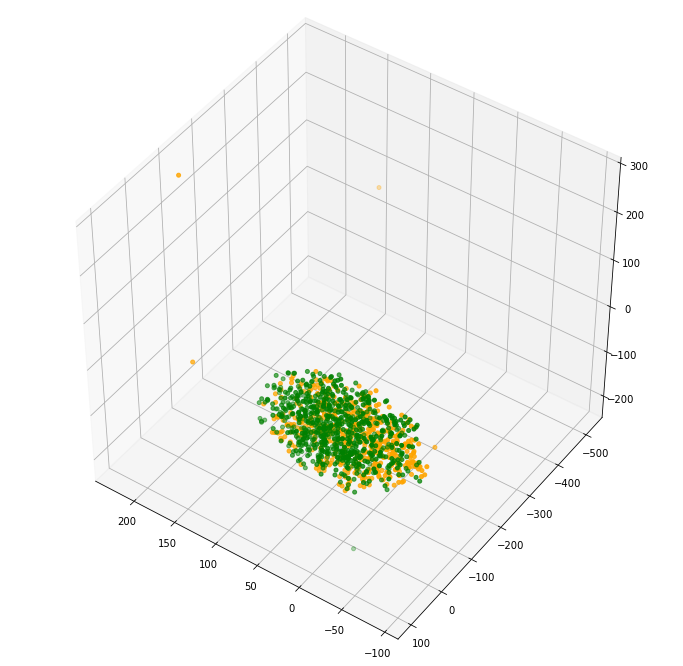

In [76]:
to_plot = pd.DataFrame(
    {
        'X': proj_w2v_train_3d[:,0], 
        'Y': proj_w2v_train_3d[:,1], 
        'Z': proj_w2v_train_3d[:,2]
    }
)
 

fig = plt.figure(figsize = (12, 12))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    to_plot['X'][idxx1], to_plot['Y'][idxx1], to_plot['Z'][idxx1], c='green', s=16
)

ax.scatter(
    to_plot['X'][idxx2], to_plot['Y'][idxx2], to_plot['Z'][idxx2], c='orange', s=16
)

ax.view_init(45, 125)
plt.show()

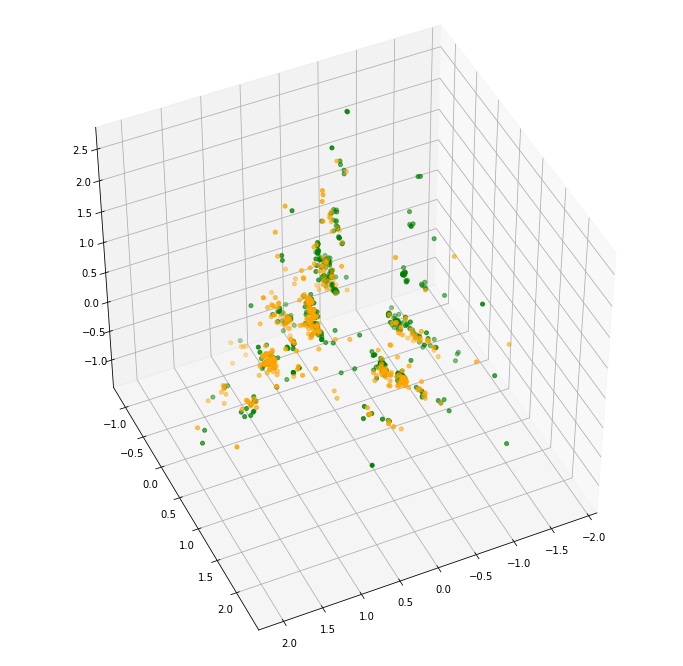

In [77]:
to_plot = pd.DataFrame(
    {
        'X': proj_bow_train_3d[:,0], 
        'Y': proj_bow_train_3d[:,1], 
        'Z': proj_bow_train_3d[:,2]
    }
)
 

fig = plt.figure(figsize = (12, 12))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    to_plot['X'][idxx1], to_plot['Y'][idxx1], to_plot['Z'][idxx1], c='green', s=16
)

ax.scatter(
    to_plot['X'][idxx2], to_plot['Y'][idxx2], to_plot['Z'][idxx2], c='orange', s=16
)

ax.view_init(45, 65)
plt.show()

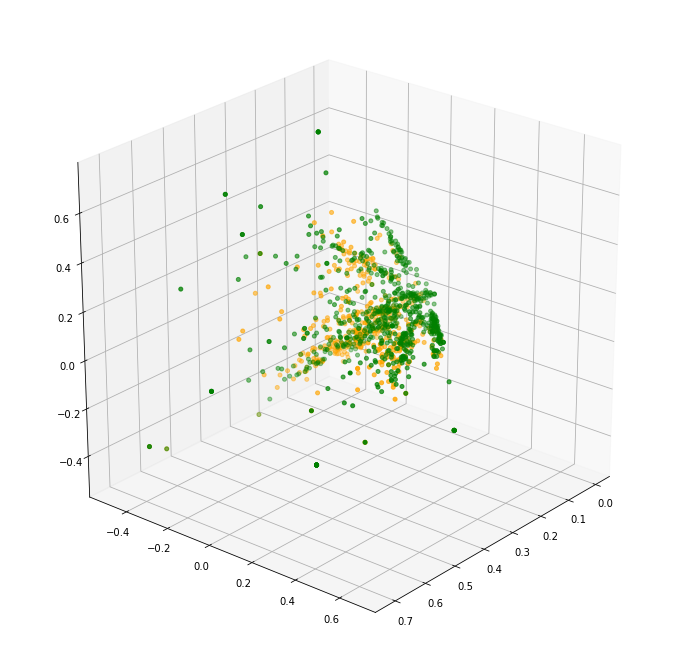

In [78]:
to_plot = pd.DataFrame(
    {
        'X': proj_tfidf_train_3d[:,0], 
        'Y': proj_tfidf_train_3d[:,1], 
        'Z': proj_tfidf_train_3d[:,2]
    }
)
 

fig = plt.figure(figsize = (12, 12))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    to_plot['X'][idxx1], to_plot['Y'][idxx1], to_plot['Z'][idxx1], c='green', s=16
)

ax.scatter(
    to_plot['X'][idxx2], to_plot['Y'][idxx2], to_plot['Z'][idxx2], c='orange', s=16
)

ax.view_init(25, 40)
plt.show()

# Train-Test Split

In [79]:
# a normal one
t_train_1, t_test_1 = train_test_split(
    df_train[['cleaned_vocab', 'label']], test_size = 0.1
)
t_train_1 = t_train_1.reset_index(drop = True)
t_test_1 = t_test_1.reset_index(drop = True)

In [80]:
# a 'balanced' one
part1 = df_train[df_train.label == 0].sample(len(df_train[df_train.label == 1]))
part2 = df_train[df_train.label == 1]

df_train_shrinked = pd.concat((part1, part2)).sample(frac = 1).reset_index(drop = True)

In [81]:
print(len(part1), len(part2))

481 481


In [82]:
df_train_shrinked

,example_id,text,label,cleaned,cleaned_vocab
0,65a1ac2c6e29222b09bd183937dfc19e,$mention$ hate you lol rt $mention$ begging de...,0,"[mention, hate, lol, mention, begging, definit...","[mention, mention, email, phishing]"
1,a763264e6d08a8da4dd841bfa33f6013,lol guess you assume don pay to play they cann...,0,"[lol, guess, assume, pay, play, predict, ddos,...","[guess, pay, play, ddos, attack, stop]"
2,264434a7535ea9e6f74b53152af4c82e,like houses on the breach then you ll love thi...,0,"[like, house, breach, love, urld0]","[like, house, breach, love]"
3,f50e0e5098781e7db524e47356434e84,malware that targets both microsoft apple oper...,1,"[malware, target, microsoft, apple, operating,...","[malware, target, microsoft, apple, system, fo..."
4,7b9cc3c3bbbbb8ae9d3d070e71dd730a,dear $mention$ please notify your it security ...,0,"[dear, mention, please, notify, security, team...","[mention, please, security, team, security, vu..."
...,...,...,...,...,...
957,1fad70e9b888460b576222714b0cd77c,hackers take aim at your $mention$ account wit...,1,"[hacker, take, aim, mention, account, new, phi...","[hacker, take, mention, account, new, phishing..."
958,97250cb8cab3ddd5fb4a5b7d6e41c284,fbi says russian hackers likely used phishing ...,1,"[fbi, say, russian, hacker, likely, used, phis...","[fbi, say, russian, hacker, likely, used, phis..."
959,61a0a61abfac50cc2dd47c55c7fb46ab,as if $mention$ data breach was nt disgraceful...,0,"[mention, data, breach, disgraceful, enough, e...","[mention, data, breach, enough, data, breach, ..."
960,b4f8a0ec50468282e2bee3a57c0fc3de,cra shuts down online services over potential ...,1,"[cra, shuts, online, service, potential, secur...","[online, service, potential, security, risk, v..."


In [83]:
t_train_2, t_test_2 = train_test_split(
    df_train_shrinked[['cleaned_vocab', 'label']], test_size = 0.1
)
t_train_2 = t_train_2.reset_index(drop = True)
t_test_2 = t_test_2.reset_index(drop = True)

# More visualizations, again

But only for the first test set

In [84]:
df_test_tfidf = tfidf_transformer.fit_transform([' '.join(e) for e in t_test_1.cleaned_vocab])

In [85]:
df_test_bow = bow_transformer.fit_transform([' '.join(e) for e in t_test_1.cleaned_vocab])

In [86]:
df_test_w2v_pretrained = get_corpus_matrix(
    t_test_1.cleaned_vocab, pretrained_model, dict(zip(full_vocab, range(len(full_vocab)))), weights = True
)

In [87]:
proj_tfidf_test = svd_model.fit_transform(df_test_tfidf)

In [88]:
proj_bow_test = pca_model.fit_transform(df_test_bow.toarray())

In [89]:
proj_w2v_test = tsne_model.fit_transform(df_test_w2v_pretrained)

In [90]:
idxx1 = t_test_1.label[t_test_1.label == 0].index
idxx2 = t_test_1.label[t_test_1.label != 0].index

c:\users\laplace-transform\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


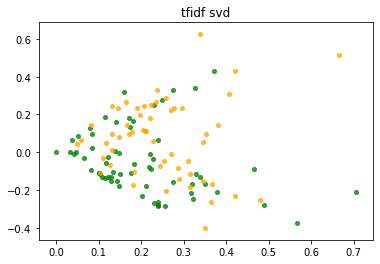

In [91]:
fast_scatter(proj_tfidf_test, idxx1, idxx2, i = 0, j = 1, text = 'tfidf svd')

c:\users\laplace-transform\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


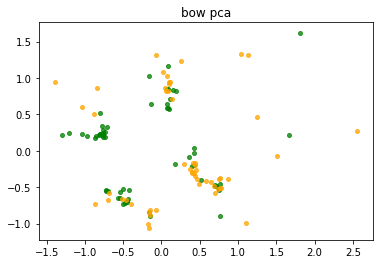

In [92]:
fast_scatter(proj_bow_test, idxx1, idxx2, i = 0, j = 1, text = 'bow pca')

c:\users\laplace-transform\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


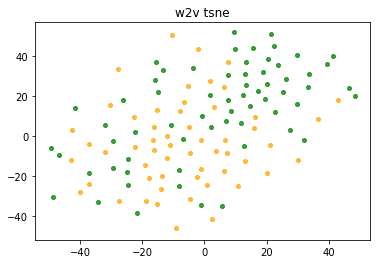

In [93]:
fast_scatter(proj_w2v_test, idxx1, idxx2, i = 0, j = 1, text = 'w2v tsne')

In [94]:
proj_tfidf_test_3d = svd_model_3d.fit_transform(df_test_tfidf)
proj_bow_test_3d = pca_model_3d.fit_transform(df_test_bow.toarray())
proj_w2v_test_3d = tsne_model_3d.fit_transform(df_test_w2v_pretrained)

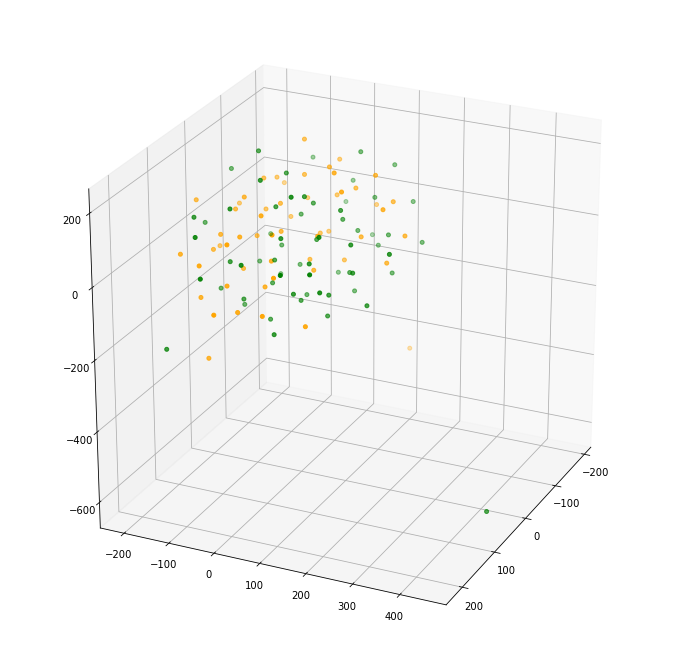

In [95]:
to_plot = pd.DataFrame(
    {
        'X': proj_w2v_test_3d[:,0], 
        'Y': proj_w2v_test_3d[:,1], 
        'Z': proj_w2v_test_3d[:,2]
    }
)
 

fig = plt.figure(figsize = (12, 12))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    to_plot['X'][idxx1], to_plot['Y'][idxx1], to_plot['Z'][idxx1], c='green', s=16
)

ax.scatter(
    to_plot['X'][idxx2], to_plot['Y'][idxx2], to_plot['Z'][idxx2], c='orange', s=16
)

ax.view_init(25, 25)
plt.show()

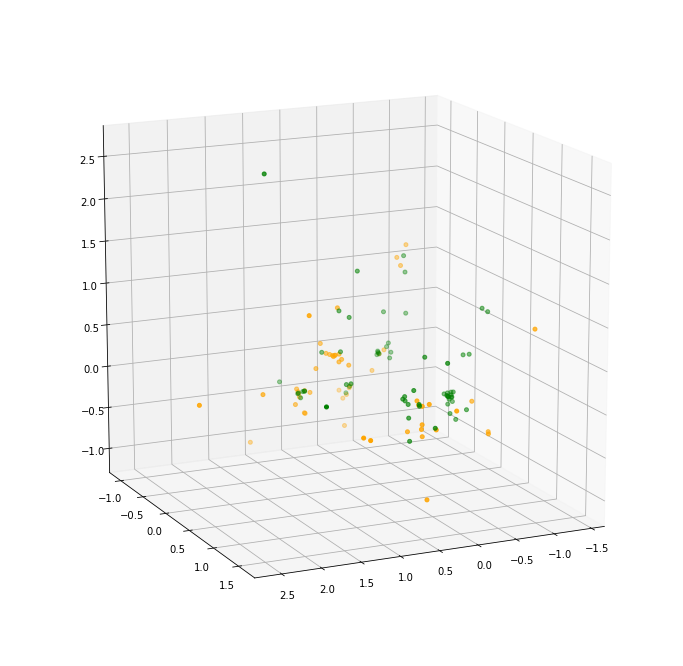

In [96]:
to_plot = pd.DataFrame(
    {
        'X': proj_bow_test_3d[:,0], 
        'Y': proj_bow_test_3d[:,1], 
        'Z': proj_bow_test_3d[:,2]
    }
)
 

fig = plt.figure(figsize = (12, 12))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    to_plot['X'][idxx1], to_plot['Y'][idxx1], to_plot['Z'][idxx1], c='green', s=16
)

ax.scatter(
    to_plot['X'][idxx2], to_plot['Y'][idxx2], to_plot['Z'][idxx2], c='orange', s=16
)

ax.view_init(15, 65)
plt.show()

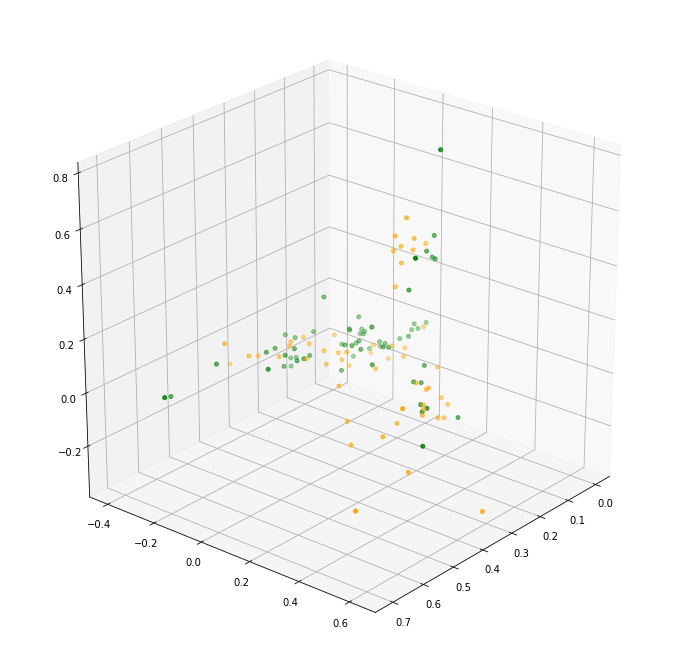

In [97]:
to_plot = pd.DataFrame(
    {
        'X': proj_tfidf_test_3d[:,0], 
        'Y': proj_tfidf_test_3d[:,1], 
        'Z': proj_tfidf_test_3d[:,2]
    }
)
 

fig = plt.figure(figsize = (12, 12))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    to_plot['X'][idxx1], to_plot['Y'][idxx1], to_plot['Z'][idxx1], c='green', s=16
)

ax.scatter(
    to_plot['X'][idxx2], to_plot['Y'][idxx2], to_plot['Z'][idxx2], c='orange', s=16
)

ax.view_init(25, 40)
plt.show()

# Text data augmentation (basic)

In [98]:
def augment(tokens_list):
    random.shuffle(tokens_list)
    return ' '.join(tokens_list)

In [99]:
#def augment_texts(frame)

In [100]:
augment(df_train.cleaned_vocab[0])

'url protection world ddos best'

# Data preparation

In [101]:
def dummy_fun(doc):
    return doc

def get_idf(tokenized_docs, max_features=180000):
    vectorizer = TfidfVectorizer(
        min_df=3,
        max_features=max_features,
        analyzer='word',
        tokenizer=dummy_fun,
        preprocessor=dummy_fun,
        token_pattern=None,
        ngram_range=(1, 1))

    vectorizer.fit(tokenized_docs)
    idf_dict = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
    
    return idf_dict

In [102]:
def get_vectors_modified(df_sample, model_w): 
    idf_dictionary = get_idf(df_sample.cleaned_vocab.tolist())
    
    X = []
    idx = []
    
    for i, tokens in enumerate(df_sample.cleaned_vocab):
        row_vectors = []
        for kw in tokens:
            try: 
                row_vectors.append(model_w[kw] * idf_dictionary[kw])
            except (IndexError, KeyError): 
                continue
        if not row_vectors:
            continue
        row_vectors = np.asarray(row_vectors)
        vec = row_vectors.mean(axis=0)
        X.append(torch.tensor(vec))
        idx.append(i)
            
    return X, idx

In [103]:
x_tr_1, id_tr_1 = get_vectors_modified(t_train_1, pretrained_model)
x_te_1, id_te_1 = get_vectors_modified(t_test_1, pretrained_model)

In [104]:
#x_tr_1 = get_corpus_matrix(t_train_1, pretrained_model, dict(zip(cleaned_vocab, range(len(cleaned_vocab)))), weights = True)
#x_te_1 = get_corpus_matrix(t_test_1, pretrained_model, dict(zip(cleaned_vocab, range(len(cleaned_vocab)))), weights = True)

In [105]:
y_tr_1 = torch.stack([torch.tensor(l, dtype=torch.float) for l in t_train_1.label[id_tr_1]])

In [106]:
x_tr_1 = torch.stack(x_tr_1)
x_te_1 = torch.stack(x_te_1)

In [107]:
x_tr_2, id_tr_2 = get_vectors_modified(t_train_2, pretrained_model)
x_te_2, id_te_2 = get_vectors_modified(t_test_2, pretrained_model)

In [108]:
#x_tr_2 = get_corpus_matrix(t_train_2, pretrained_model, dict(zip(cleaned_vocab, range(len(cleaned_vocab)))), weights = True)
#x_te_2 = get_corpus_matrix(t_test_2, pretrained_model, dict(zip(cleaned_vocab, range(len(cleaned_vocab)))), weights = True)

In [109]:
y_tr_2 = torch.stack([torch.tensor(l, dtype=torch.float) for l in t_train_2.label[id_tr_2]])

In [110]:
x_tr_2 = torch.stack(x_tr_2)
x_te_2 = torch.stack(x_te_2)

In [111]:
x_test, idx_test_2 = get_vectors_modified(df_test, pretrained_model)

In [112]:
#x_test = get_corpus_matrix(df_test, pretrained_model, dict(zip(cleaned_vocab, range(len(cleaned_vocab)))), weights = True)

In [113]:
x_test = torch.stack(x_test)

# SVC

In [114]:
#def fast_plot(Y, name1, name2, axs = None): 
#    X = range(1, len(Y)+1) 
#    sns.lineplot(
#        x = name1, y = name2, 
#        data = pd.DataFrame(np.vstack((X, Y)).T, columns=[name1, name2]), ax = axs
#    )

In [115]:
#def plot_svc_var(c_array, x_tr, y_tr, x_te, y_te):
    

# Train-test 1

In [116]:
svc_model = SVC(
    C = 1,
    kernel = 'rbf',
    random_state = opt_seed
)

In [117]:
svc_model.fit(x_tr_1, y_tr_1)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=9, shrinking=True, tol=0.001,
    verbose=False)

In [118]:
pred_svc = svc_model.predict(x_te_1)

In [119]:
set(pred_svc)

{0.0, 1.0}

In [120]:
print(classification_report(t_test_1.label[id_te_1], pred_svc))

              precision    recall  f1-score   support

           0       0.70      0.89      0.78        63
           1       0.82      0.56      0.67        55

    accuracy                           0.74       118
   macro avg       0.76      0.73      0.72       118
weighted avg       0.75      0.74      0.73       118



In [122]:
pred_svc_to_df = np.array(svc_model.predict(x_test), dtype = bool)

In [123]:
prediction_df = frame_predictions(df_test, pred_svc_to_df, idx_test_2)

c:\users\laplace-transform\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [124]:
prediction_df.to_csv(os.getcwd() + os.sep + "SVC_whatever_I_rbf_results_horbunov.csv", index = False)

# Train-test 2

In [125]:
svc_model = SVC(
    C = 1,
    kernel = 'rbf',
    random_state = opt_seed
)

In [126]:
svc_model.fit(x_tr_2, y_tr_2)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=9, shrinking=True, tol=0.001,
    verbose=False)

In [127]:
#pred_svc = np.array(svc_model.predict(x_test), dtype = bool)
pred_svc = np.array(svc_model.predict(x_te_2), dtype = bool)

In [128]:
set(pred_svc)

{False, True}

In [129]:
print(classification_report(t_test_2.label[id_te_2], pred_svc))

              precision    recall  f1-score   support

           0       0.72      0.75      0.74        52
           1       0.70      0.67      0.68        45

    accuracy                           0.71        97
   macro avg       0.71      0.71      0.71        97
weighted avg       0.71      0.71      0.71        97



In [130]:
pred_svc_to_df = np.array(svc_model.predict(x_test), dtype = bool)

In [131]:
prediction_df = frame_predictions(df_test, pred_svc_to_df, idx_test_2)

c:\users\laplace-transform\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [132]:
prediction_df.to_csv(os.getcwd() + os.sep + "SVC_awhatever_rbf_results_horbunov.csv", index = False)

# KNN

In [136]:
from sklearn.neighbors import KNeighborsClassifier

In [143]:
lreg = KNeighborsClassifier()
lreg.fit(x_tr_1, y_tr_1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [144]:
ssss = np.array(lreg.predict(x_te_1), dtype = bool)

In [145]:
print(classification_report(t_test_1.label[id_te_1], ssss))

              precision    recall  f1-score   support

           0       0.63      0.84      0.72        63
           1       0.71      0.44      0.54        55

    accuracy                           0.65       118
   macro avg       0.67      0.64      0.63       118
weighted avg       0.67      0.65      0.64       118



In [146]:
lreg = KNeighborsClassifier()
lreg.fit(x_tr_2, y_tr_2)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [147]:
ssss = np.array(lreg.predict(x_te_2), dtype = bool)

In [148]:
print(classification_report(t_test_2.label[id_te_2], ssss))

              precision    recall  f1-score   support

           0       0.64      0.73      0.68        52
           1       0.63      0.53      0.58        45

    accuracy                           0.64        97
   macro avg       0.64      0.63      0.63        97
weighted avg       0.64      0.64      0.64        97



X_train_matrix.shape

X_train_matrix.shape

lrcl = LogisticRegression(
    C = 4.5, solver = 'liblinear', multi_class = 'ovr'
).fit(X_train_matrix, df_train.label)

prediction = lrcl.predict(X_test_matrix)

print(classification_report(fsdf, prediction))

prediction_df = frame_predictions(df_test, prediction, df_test.index)

prediction_df.to_csv(os.getcwd() + os.sep + "LR_results_horbunov.csv", index = False)

fsdf = pd.read_csv('FFNN_results_horbunov.csv').label

# Feed Forward Neural Network

X_train, idx_train = get_vectors_modified(df_train, pretrained_model)
X_test, idx_test = get_vectors_modified(df_test, pretrained_model)

y_train = torch.stack([torch.tensor(l, dtype=torch.float) for l in df_train.label[idx_train]])

X_train = torch.stack(X_train)
X_test = torch.stack(X_test)

print(len(X_train), len(y_train))

In [149]:
def make_predictions_mod(model, x_test, threshold, batch_size):
    predictions = []
    
    x_batches = torch.chunk(x_test, batch_size)
    
    for i in range(len(x_batches)):
        x_true = x_batches[i]
        
        y_pred = model(x_true).detach().squeeze().numpy()
        y_pred = [int(prob.item() > threshold) for prob in y_pred]
        
        predictions.extend(y_pred)

    return predictions

class FeedForwardModified(nn.Module):
    
    def __init__(self, input_size, s1, s2):
        super().__init__()

        self.input_size = input_size

        self.s1 = s1
        self.s2 = s2
        
        self.fc1 = nn.Linear(self.input_size, self.s1)
        self.fc2 = nn.Linear(self.s1, self.s2)
        self.fc3 = nn.Linear(self.s2, 1)

        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        hidden_1 = self.fc1(x)
        hidden_1_a = self.relu(hidden_1)
        
        hidden_2 = self.fc2(hidden_1_a)
        hidden_2_a = self.tanh(hidden_2)

        pre_output = self.fc3(hidden_2_a)
        output = self.sigmoid(pre_output)

        return output

model = FeedForwardModified(300, 300, 160)

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.07) # 0.075

loss_train = []
n_epochs = 30
batch_size = 10
n_iters = len(X_train) // batch_size

model.train()

for epoch in range(n_epochs):  
    epoch_loss = 0
    
    for i in range(n_iters):
        optimizer.zero_grad()
        
        idx = random.sample(range(len(X_train)), batch_size)
        x = X_train[idx]
        y_true = y_train[idx]
        y_pred = model(x)
        
        loss = criterion(y_pred.squeeze(), y_true)
        epoch_loss += loss.item() / n_iters

        loss.backward()
        optimizer.step()
    
    loss_train.append(epoch_loss)

    print('Epoch {:2}: train loss: {:12.6}'.format(epoch+1, epoch_loss))

In [158]:
def fast_plot(Y, name, axs = None):
    X = range(1, len(Y)+1)
    sns.lineplot(
        x = "epochs", y = name, 
        data = pd.DataFrame(np.vstack((X, Y)).T, columns=["epochs", name]), ax = axs
    )

f, a = plt.subplots(1, 1, figsize = (14, 8))

fast_plot(loss_train, "train_loss", axs = a)

model.eval()
predictions = np.array(
    make_predictions_mod(model, X_test, threshold=0.5, batch_size=batch_size), dtype = bool
)

prediction_df = frame_predictions(df_test, predictions, idx_test)

prediction_df.to_csv(os.getcwd() + os.sep + "FFNN_results_horbunov.csv", index = False)

0.73 -- lr 0.05 300 300 160 e 15 b 4
0.71 -- lr 0.05 300 300 160 e 15 b 4
0.74418 -- lr 0.05 300 300 160 e 20 b 16

torch.save(model.state_dict(), os.getcwd() + os.sep + "FFNN_300_300_160_07_e30_b10_076_F1.pth")

0.75576

# Feed Forward Neural Network (advanced)

In [150]:
class FeedForwardEnchanced(nn.Module):
    
    def __init__(self, input_size, s1, s2):
        super().__init__()

        self.fc1 = nn.Linear(input_size, s1)
        self.fc2 = nn.Linear(s1, s2)
        self.fc3 = nn.Linear(s2, 1)

        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        
        l1 = self.fc1(x)
        l1a = self.relu(l1)
        
        l2 = self.fc2(l1a)
        l2a = self.tanh(l2)
        
        l3 = self.fc3(l2a)
        l3a = self.sigmoid(l3)

        return l3a

# Train-test 1

In [170]:
model = FeedForwardEnchanced(300, 300, 180)

In [171]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.025)

In [172]:
loss_train = []
n_epochs = 16
batch_size = 4
n_iters = len(x_tr_1) // batch_size

model.train()

for epoch in range(n_epochs):  
    epoch_loss = 0
    
    for i in range(n_iters):
        optimizer.zero_grad()
        
        idx = random.sample(range(len(x_tr_1)), batch_size)
        x = x_tr_1[idx]
        y_true = y_tr_1[idx]
        y_pred = model(x)
        
        loss = criterion(y_pred.squeeze(), y_true)
        epoch_loss += loss.item() / n_iters

        loss.backward()
        optimizer.step()
    
    loss_train.append(epoch_loss)

    print('Epoch {:2}: train loss: {:12.6}'.format(epoch+1, epoch_loss))

Epoch  1: train loss:     0.652054
Epoch  2: train loss:     0.529865
Epoch  3: train loss:      0.41058
Epoch  4: train loss:     0.376903
Epoch  5: train loss:     0.382973
Epoch  6: train loss:     0.348056
Epoch  7: train loss:     0.306632
Epoch  8: train loss:     0.286777
Epoch  9: train loss:     0.244379
Epoch 10: train loss:     0.254614
Epoch 11: train loss:     0.211174
Epoch 12: train loss:     0.187395
Epoch 13: train loss:     0.197328
Epoch 14: train loss:     0.148024
Epoch 15: train loss:     0.173315
Epoch 16: train loss:     0.143533


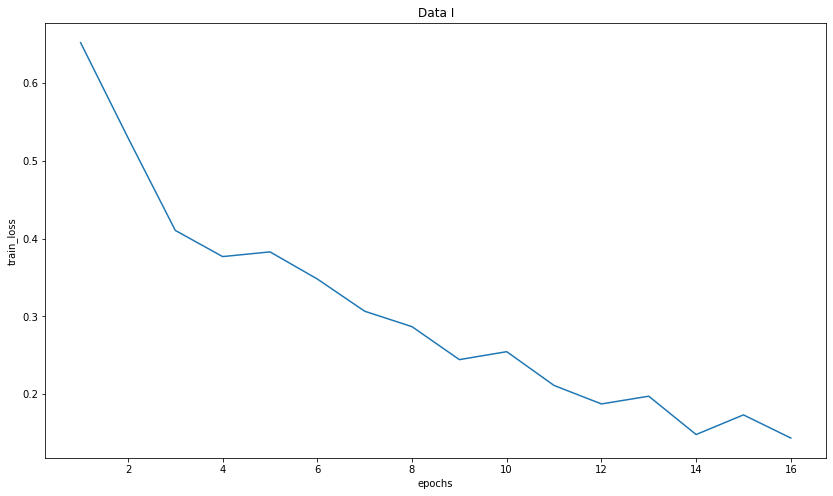

In [176]:
f, a = plt.subplots(1, 1, figsize = (14, 8))
a.set_title("Data I")
fast_plot(loss_train, "train_loss", axs = a)

In [174]:
model.eval()
pred_1 = np.array(
    make_predictions_mod(model, x_te_1, threshold=0.5, batch_size=batch_size), dtype = bool
)

In [175]:
print(classification_report(t_test_1.label[id_te_1], pred_1))

              precision    recall  f1-score   support

           0       0.71      0.62      0.66        63
           1       0.62      0.71      0.66        55

    accuracy                           0.66       118
   macro avg       0.66      0.66      0.66       118
weighted avg       0.67      0.66      0.66       118



# Train-test 2

model = FeedForwardEnchanced(300, 500, 200)

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05)

loss_train = []
n_epochs = 25
batch_size = 24
n_iters = len(x_tr_2) // batch_size

model.train()

for epoch in range(n_epochs):  
    epoch_loss = 0
    
    for i in range(n_iters):
        optimizer.zero_grad()
        
        idx = random.sample(range(len(x_tr_2)), batch_size)
        x = x_tr_2[idx]
        y_true = y_tr_2[idx]
        y_pred = model(x)
        
        loss = criterion(y_pred.squeeze(), y_true)
        epoch_loss += loss.item() / n_iters

        loss.backward()
        optimizer.step()
    
    loss_train.append(epoch_loss)

    print('Epoch {:2}: train loss: {:12.6}'.format(epoch+1, epoch_loss))

f, a = plt.subplots(1, 1, figsize = (14, 8))

fast_plot(loss_train, "train_loss", axs = a)

model.eval()
pred_1 = np.array(
    make_predictions_mod(model, x_te_2, threshold=0.3, batch_size=batch_size), dtype = bool
)

print(classification_report(t_test_2.label[id_te_2], pred_1))

model.eval()
predictions = np.array(
    make_predictions_mod(model, x_test, threshold=0.3, batch_size=batch_size), dtype = bool
)

prediction_df = frame_predictions(df_test, predictions, idx_test_2)

prediction_df.to_csv(os.getcwd() + os.sep + "FFNN_II_results_horbunov.csv", index = False)

# Recurrent Neural Network

class ModelRNN(nn.Module):
    
    def __init__(self, n_tok, n_emb = 300, n_hid1 = 200, n_hid2 = 100):
        
        super(self.__class__, self).__init__()
        
        self.emb = nn.Embedding(n_tok, n_emb)
        self.rnn = nn.RNN(n_emb, n_hid1, batch_first = True)
        self.hid1 = nn.Linear(n_hid1, n_hid2)
        self.hid2 = nn.Linear(n_hid2, 1)
        
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, l_seq):
        
        emb = self.emb(x)
        
        packed = torch.nn.utils.rnn.pack_padded_sequence(
            emb, l_seq, batch_first = True, enforce_sorted = False
        )
        
        possible_hid_states, hid = self.rnn(packed)
        hid_activ = self.hid1(hid)
        hid_activ_post = self.tanh(hid_activ)
        
        out = self.hid2(hid_activ_post)
        out_post = self.sigmoid(out)
        
        return out_post

df_train_filtered = df_train[df_train.cleaned_vocab.astype('str') != '[]']
df_test_filtered = df_test[df_test.cleaned_vocab.astype('str') != '[]']

def to_vector(text_series, token_to_id, l_max = None, dtype = 'int32'):
    l_seq = list(map(len, text_series))
    l_max = l_max or max(map(len, text_series))
    
    series_idx = np.zeros((len(text_series), l_max), dtype) + token_to_id[" "]
    
    for j in range(len(text_series)):
        current_idx = [token_to_id[u] for u in text_series[j]]
        series_idx[j, :len(current_idx)] = current_idx
        
    return series_idx, l_seq

model = ModelRNN(
    n_tok=len(full_vocab),
    n_emb = 280,
    n_hid1 = 220,
    n_hid2 = 100
)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

batch_size = 2
n_epochs = 10
n_iters = df_train_filtered.shape[0] // batch_size

Y_train_loss = []

for epoch in range(n_epochs):
    epoch_loss = 0 
    for step in range(n_iters):

        optimizer.zero_grad()
        
        sample = df_train_filtered.sample(batch_size)
        
        batch_ix, seq_lengths = to_vector(
            sample.cleaned_vocab.tolist(), token_to_id
        ) 
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

        y_true = sample.label.tolist()
        y_true = torch.tensor(y_true, dtype=torch.float)

        y_pred = model(batch_ix, seq_lengths)
        loss = criterion(y_pred.squeeze(), y_true)

        epoch_loss += loss.item() / n_iters
        loss.backward()
        
        optimizer.step()
            
    Y_train_loss.append(epoch_loss)
    
    print('Epoch {:2}: train loss: {:8.6}'.format(epoch, epoch_loss))

plt.figure(figsize = (12, 8))

sns.lineplot(
    x = "epochs", y = "loss", 
    data = pd.DataFrame(
        np.vstack((range(1, len(Y_train_loss)+1), Y_train_loss)).T, 
        columns=["epochs", "loss"]
    )
)

def index_marks(nrows, chunk_size):
    return range(1 * chunk_size, (nrows // chunk_size + 1) * chunk_size, chunk_size)

def split(df, chunk_size):
    indices = index_marks(df.shape[0], chunk_size)
    return np.split(df, indices)

def make_predictions(model, df_test, batch_size, threshold): 
    test_batches = split(df_test, batch_size)
    
    predictions = []
    
    for batch in test_batches:
        #print(batch.cleaned_vocab.tolist())
        batch_ix, seq_lengths = to_vector(
            batch.cleaned_vocab.tolist(), token_to_id
        )
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

        y_pred = model(batch_ix, seq_lengths).detach().squeeze().numpy()
        
        if y_pred.shape == ():
            y_pred = [y_pred]
        
        y_pred = [int(pred.item() > threshold) for pred in y_pred]
        
        predictions.extend(y_pred)
        
    return predictions

predictions = np.array(make_predictions(model, df_test_filtered, batch_size, threshold=0.3), dtype = bool)

non_evaluated_rows_idx = np.array(np.setdiff1d(df_test.index, df_test_filtered.index), dtype = 'int32')

prediction_df = frame_predictions(df_test, predictions, df_test_filtered.index)

len(prediction_df[prediction_df['label'] == 1]) + len(prediction_df[prediction_df['label'] == 0]) == 786

prediction_df.to_csv(os.getcwd() + os.sep + "RNN_results_horbunov.csv", index = False)